<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 3</h1>

<span style='color:red'>**TW:**
Add some introductory text. "In this tutorial, we will..." and also address **why** we care to do it. Some of the text from the data cleaning section below might migrate up here. We will want to be include this for all tutorial chapters.
<span>

<br>

**Authors:** John Letey, Mingxuan Zhang, and Tony E. Wong

### Table of Contents

- [Packages](#packages)
- [Data Cleaning](#data-cleaning)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#amha)
- [Running the Algorithm](#running-algo)
- [History Plots For Each Parameter](#history-plots)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic)
- [Auto Correlation Function Results](#ac-function)
- [Histograms For Each Parameter](#histograms)
- [Max Log-Posterior Score Parameter Set](#max-ls)
- [Diagnostic Plots](#diag-plots)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [27]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use("fivethirtyeight")
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

<a id='data-cleaning'></a>
***
<h2 align="center">Data Cleaning</h2>
[Back to top](#top)

<br>

For this tutorial, the hourly sea level data set we are going to analyze is from [The University of Hawaii Sea-Level Center](https://uhslc.soest.hawaii.edu/data/?rq), and we will try to fit the annual maxima sea level for Galveston by using a GEV distribution and what we have learned in the previous tutorial chapters!

<span style='color:red'>**TW:**
Set this up in more detail as a parameter estimation problem. It will almost certainly make more sense how to set it up after you've written Part 2, about estimating unknown parameters for a normal or GEV distribution. But that's how you want to motivate this. Also be sure to include the ***physical*** reason for doing this, which is that we want to know what storm surge heights are expected with what return periods. Try to use your own words, and include a paragraph setting the stage, and then another paragraph introducing the GEV distribution as a tool to estimate storm surge return levels.
<span>

Before we start our MCMC algorithm, we have to do some Data Cleaning, since it is typical to have missing values for these kind of data sets, and usually people will use fill-in values for these missing data. Therefore, we have to find the fill-in value, and drop all of them.

First, let's take a look at the raw data set.

<span style='color:red'>**TW:**
Also need to introduce the renaming of the columns - just say we're going to give th ecolumns more meaningful names.
<span>

In [2]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
dfSL.head()

,year,month,day,hour,sealevel
0,1904,1,1,6,961
1,1904,1,1,7,992
2,1904,1,1,8,961
3,1904,1,1,9,900
4,1904,1,1,10,809


<span style='color:red'>**TW:**
The line width is pretty wide, so it is tough to tell what this looks like. And we can't quite actually see where the fill value is, because the axis is trimmed juuuust above it. $$$$
Time (in hours) doesn't tell us everythign we need to know about the x-axis scale. Relative to what?  And "mm" not "MM" is the appropriate abbreviation for millimeters
<span>

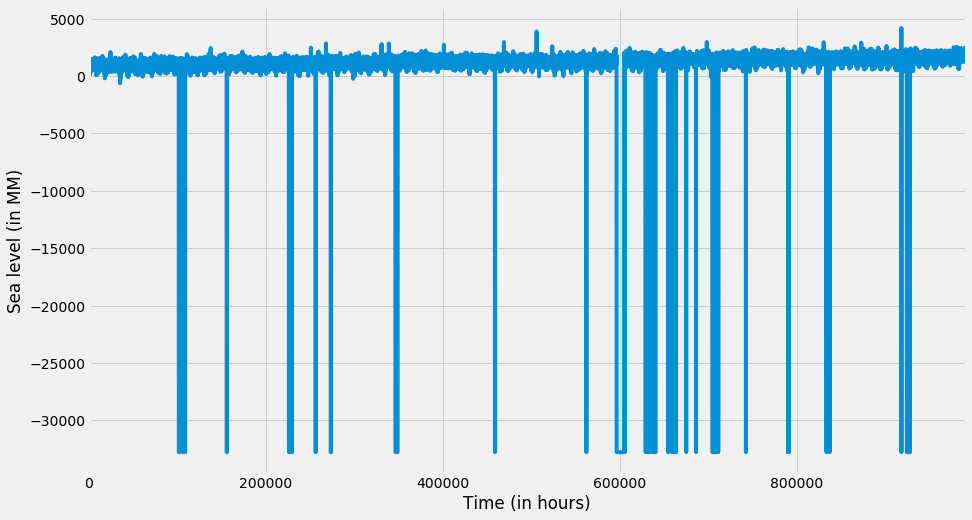

In [3]:
plt.figure(figsize=(14, 8))
dfSL['sealevel'].plot()
plt.xlabel('Time (in hours)')
plt.ylabel('Sea level (in MM)')
plt.show()

<br>

The long vertical lines in the above graph are telling us there are some missing values, so let's find them. Since the fill-in value is some negative small constant (which you can tell from the graph above) it is easy to find them. The following code will do the job:

<span style='color:red'>**TW:**
give a sentence explaining why that code should work. doesn't need to be in great detail, but at least say what we're doing because while it is obvious to us, it might not be obvious to others
<span>

In [4]:
fill_in = dfSL.loc[dfSL['sealevel'] < -5000, "sealevel"].median()
print ('The fill in value is {0}'.format(fill_in))

The fill in value is -32767.0


<br>

<span style='color:red'>**TW:**
Drop all of them how? We haven't really gone over any data cleaning techniques in the first couple tutorials, so this is a great place to include a brief description of the dropna method and provide a link to the man page on it. Use the in-class notebooks for CSCI 3022, 3202 and 4622 as a guide for this.
$$$$
Revise the parenthetical comment about units to be grammatically correct, and make sure the units on the below plot are consistent with however you revise the units above. Let's also give the plot a more informative title, maybe somethign including the location of the data set and what it is (tide gauge, Galveston, Texas, hourly sea level measurements, etc are all good words to include)
<span>

Now, since we knew what is the fill-in value, we can drop all of them, and take a look at the data set again! (Note that the unit for the sea level is millimeters):

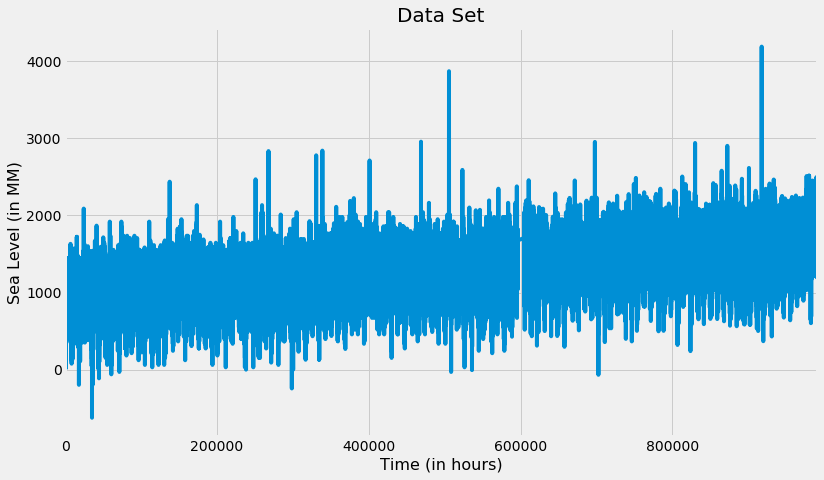

In [5]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace= True)
plt.figure(figsize=(12, 7))
dfSL['sealevel'].plot()
plt.title('Data Set', fontsize=20)
plt.xlabel('Time (in hours)',  fontsize=16)
plt.ylabel('Sea Level (in MM)',  fontsize=16)
plt.show()

<br>

<span style='color:red'>**TW:**
Before we insist on having enough data each year, we need to introduce **why** we care about having enough data. That is, there are cycles and dependencies within the data that will introduce biases if we are misisng too much data from a given year. That's because of how this block maxima approach works, where we are looking at the maximum of each 1-year block of hourly measurements. So, if we are missing too many data points, we are not going to have a representative sampling of the sea levels observed in that year. These are critically important analysis steps - be sure you are clear on why we are doing each one and ask if you aren't sure!
<span>

Before we extract the annual maxima sea level for each year, we have to find the years which are good enough to use. Why? Because if one particular year has a lot of missing data, the annual maximum sea level for that year is inaccurate! The threshold is we will only use the years where the number of missing values are less or equal to **10%** of that year.

In [6]:
n_hours = 365*24

sl_year = {}

for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
max_sl = {}

for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        max_sl[year] = max(np.array(sealevel)-np.mean(sealevel))

<br>

<span style='color:red'>**TW:**
It's a matter of preference, but I strongly prefer to include white border around each histogram blcok. So include "edgecolor="white"" in the hist call.
<span>

Now, we are ready to go! Let's take a look at the histogram of the annual maximum sea level at Galveston!

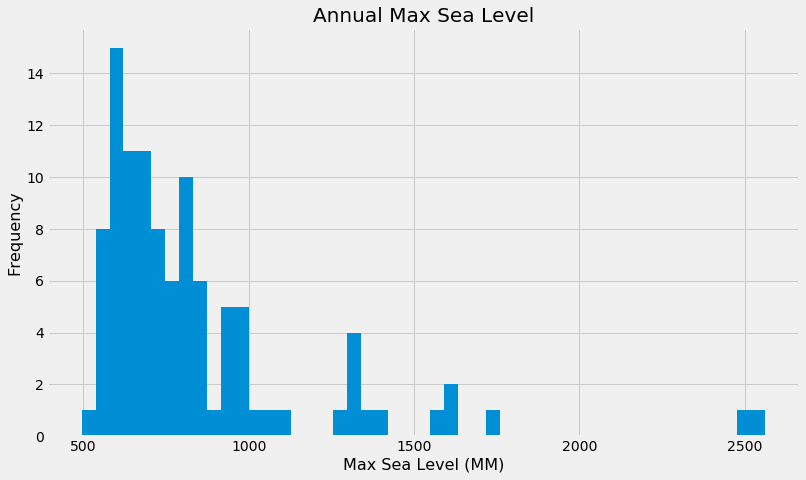

There are 103 years we can use


In [7]:
data_meas = list(max_sl.values())

plt.figure(figsize=(12, 7))
plt.hist(x=data_meas, bins=np.linspace(min(data_meas), max(data_meas)))
plt.title('Annual Max Sea Level', fontsize=20)
plt.xlabel('Max Sea Level (MM)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()
print ('There are {0} years we can use'.format(len(data_meas)))

<a id='log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Chapter 2?  Also, let's be consistent whether we are referring to the different chapters as "Chapter X" or "Part X". Check this throughout all of the Chapters (or Parts)
<span>

Since we are dealing with GEV distribution again, we will use the same log-likelihood function from chapter 2B:

In [8]:
def loglikelihood(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Same two comments as above.  And let's also reiterate that we are using wide uniform distributions for the priors.
<span>

We will also use the same log-prior distribution from chapter 2B!

In [9]:
def logprior(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf

***

<a id='log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

<span style='color:red'>**TW:**
You can lump all three of the log-prior, -likelihood and -posterior score together in a single section for brevity's sake. And we want to include just a couple sentences saying we're using all the same stuff and here they are
<span>

In [10]:
def logpost(parameters, data_meas):
    pi = logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
This can also be lumped in with the likelihood function/prior/posterior above if it's all the same as before. And check for consistency in referring to chapters/parts. "Adaptive" shouldn't be capitalized since there are a variety of adaptive algorithms. And "MCMC" is not techinically the name of the algorithm but rather the sampling method. Rather, it's an adaptive variety of the Metropolis-Hastings algorithm. $$$$
Also, include references for Metropolis 1953 and Hastings 1971 (both of these for the original MH algorithm), and Haario et al 2001 (for the adaptive MH algorithm) $$$$
Lastly, whatever you decide with regard to the class OOD structure for Chapter 1, stick with it in CHapter 2 and 3 as well. My feeling is that it will make things a bit more complicated than they really need to be.
<span>

Same set up for Adaptive MCMC algorithm as Chapter 2B!

In [80]:
def update_mean(m, X):
    N = len(X[0])
    n = []
    for i in range(len(m)):
        n.append((m[i]*(N-1) + X[i][-1])/N)
    return n

def update_cov(X, m, t, Ct, Sd, Id, eps):
    m1 = update_mean(m, X)
    part1 = ((t-1)/t)*Ct
    part2 = (t*np.matmul(m, np.transpose(m))) - ((t+1)*np.matmul(m1, np.transpose(m1)))
    part3 = (Sd/t)*(part2 + np.matmul(X, np.transpose(X)) + eps*Id )
    cov =  part1 + part3
    return 1/2 * (cov + np.transpose(cov)), m1

class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t, d):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        self.I_d = np.identity(d)
        self.S_d = (2.4)**2/d
        self.d = d
        
    def random_move(self, t, X, m, Ct):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
            return next_move, self.logpost(next_move, self.data_meas), m, self.stepsize
        elif (t == self.t + 1):
            n = []
            for i in range(len(X)):
                n.append(np.mean(X[i]))
            cov = self.S_d*np.cov(X) + self.I_d*0.0001*self.S_d
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
            return next_move, self.logpost(next_move, self.data_meas), n, cov
        elif (t >= self.t+2):
            cov, m1 = update_cov(X, m, t, Ct, self.S_d, self.I_d, 0.0001)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
            return next_move, self.logpost(next_move, self.data_meas), m1, cov
        
        '''
        def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = self.S_d*np.cov(X) + self.I_d*0.0001*self.S_d
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)
        '''

In [73]:
def adaptivemcmc(problem, n_iter):
    parameters = []
    for i in range(problem.d):
        parameters.append([])
        parameters[i].append(problem.current.state[i])
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    cov = problem.stepsize
    m = []
    for t in range(n_iter):
        S += 1
        nextMove, nextValue, m, cov = problem.random_move(t, parameters, m, cov)
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            for i in range(problem.d):
                parameters[i].append(nextMove[i])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                for i in range(problem.d):
                    parameters[i].append(nextMove[i])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                for i in range(problem.d):
                    parameters[i].append(parameters[i][-1])
                lpost.append(lpost[-1])

    return (parameters, lpost, n_accept/S)

***

***
<h2 align="center">Gelman-Rubin Diagnostic</h2>
[Back to top](#top)

<br>

In [74]:
def GR_diag(parameter, interval=100, start=100):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

def GR_result(mcmc_chains, params, t, start=100, interval=100, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_raw, GR_params, burnin_params = [], [], []
    start, interval, end = start, interval, n
    for i in range(d):
        params_raw.append([])
        for j in range(m):
            params_raw[i].append(mcmc_chains[j][i])
    for i in range(d):
        GR, burnin = GR_diag(params_raw[i], interval, start)
        GR_params.append(GR)
        burnin_params.append(burnin)
    burnin = max(max(burnin_params), t)
    if plot:
        plt.figure(figsize=(14, 6))
        for i in range(d):
            plt.scatter(x=np.arange(start, end, interval), y=GR_params[i], label=params[i], color=COLORS[i % 3])
        plt.plot([burnin, burnin], plt.ylim(), label='burn in = {0}'.format(burnin))
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return burnin

***

***
<h2 align="center">Auto Correlation Function</h2>
[Back to top](#top)

<br>

In [75]:
def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ('Please increase the value of the end parameter for this function')
    return lag, acf

def acf_result(mcmc_chains, params, burnin, plot=True):
    lag_params, acf_params = [], []
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    end = 100
    for i in range(d):
        lag_params.append([])
        acf_params.append([])
        for j in range(m):
            lag, acf = ACF(mcmc_chains[j][i][burnin:], end)
            lag_params[i].append(lag)
            acf_params[i].append(acf)
    lags = [max(np.array(lag_params)[:,i]) for i in range(m)]
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
        for i in range(m):
            for j in range(d):
                ax[i].scatter(np.arange(0, end), acf_params[j][i], label=params[j], color=COLORS[j % 3])
                ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_params[j][i]), y1=acf_params[j][i], alpha=0.3, facecolor='skyblue')
            ax[i].plot([lags[i],lags[i]], ax[i].get_ylim(), label='lag = {0}'.format(lags[i]))
            ax[i].set_xlabel("Iag")
            ax[i].set_ylabel("ACF")
            ax[i].set_title("Sequence {0}".format(i+1))
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()
    return lags

<span style='color:red'>**TW:**
The GR diagnostic and ACF stuff for thinning can also be put into just a single code block. They could even be put down at the end of the notebook as helper functions, with some links. Just try to condense all the stuff from previous notebooks. And include at least a shout-out to each block of code saying what it is that we are bringing in from old notebooks.
<span>

***

<a id='running-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
In text, include commas for thousands/millions/billions etc. separation $$$$
It is also customary to include numbers zero through ten as spelled out words, and 11 and above as numerals. So three would be written out, but 10,000 would appear as numbers.
<span>

Finally, we can start the MCMC algorithm, We will generate 3 sequences each with 10000 iterations and start the adaption when iteration = 1000

<span style='color:red'>**TW:**
Not the MCMC algorithm, but rather the Metropolis-Hastings algorithm.
<span>

In [76]:
def sequences_generator(m, n_iter, data_meas, logpost, d, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)
    
    if logpost([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]
        
    elif logpost([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1
        
    elif logpost([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1
        
    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0
        
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t, d))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(problems[i], n_iter)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

<span style='color:red'>**TW:**
HERE is where you should include a bit of text saying what the simulation parameters are (number of parallel chains, number of iterations, etc)
<span>

In [77]:
t=1000
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=4000, t=t, d=3, logpost=logpost, data_meas=data_meas)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


***

<a id='history-plots'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Give a description of what this is. It doesn't need to be in as much detail as before, but just to introduce and segue from one section to the next.
<span>

In [78]:
def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()

<span style='color:red'>**TW:**
These line widths ought to be narrower so that we can actually make out the behavior of each chain
<span>

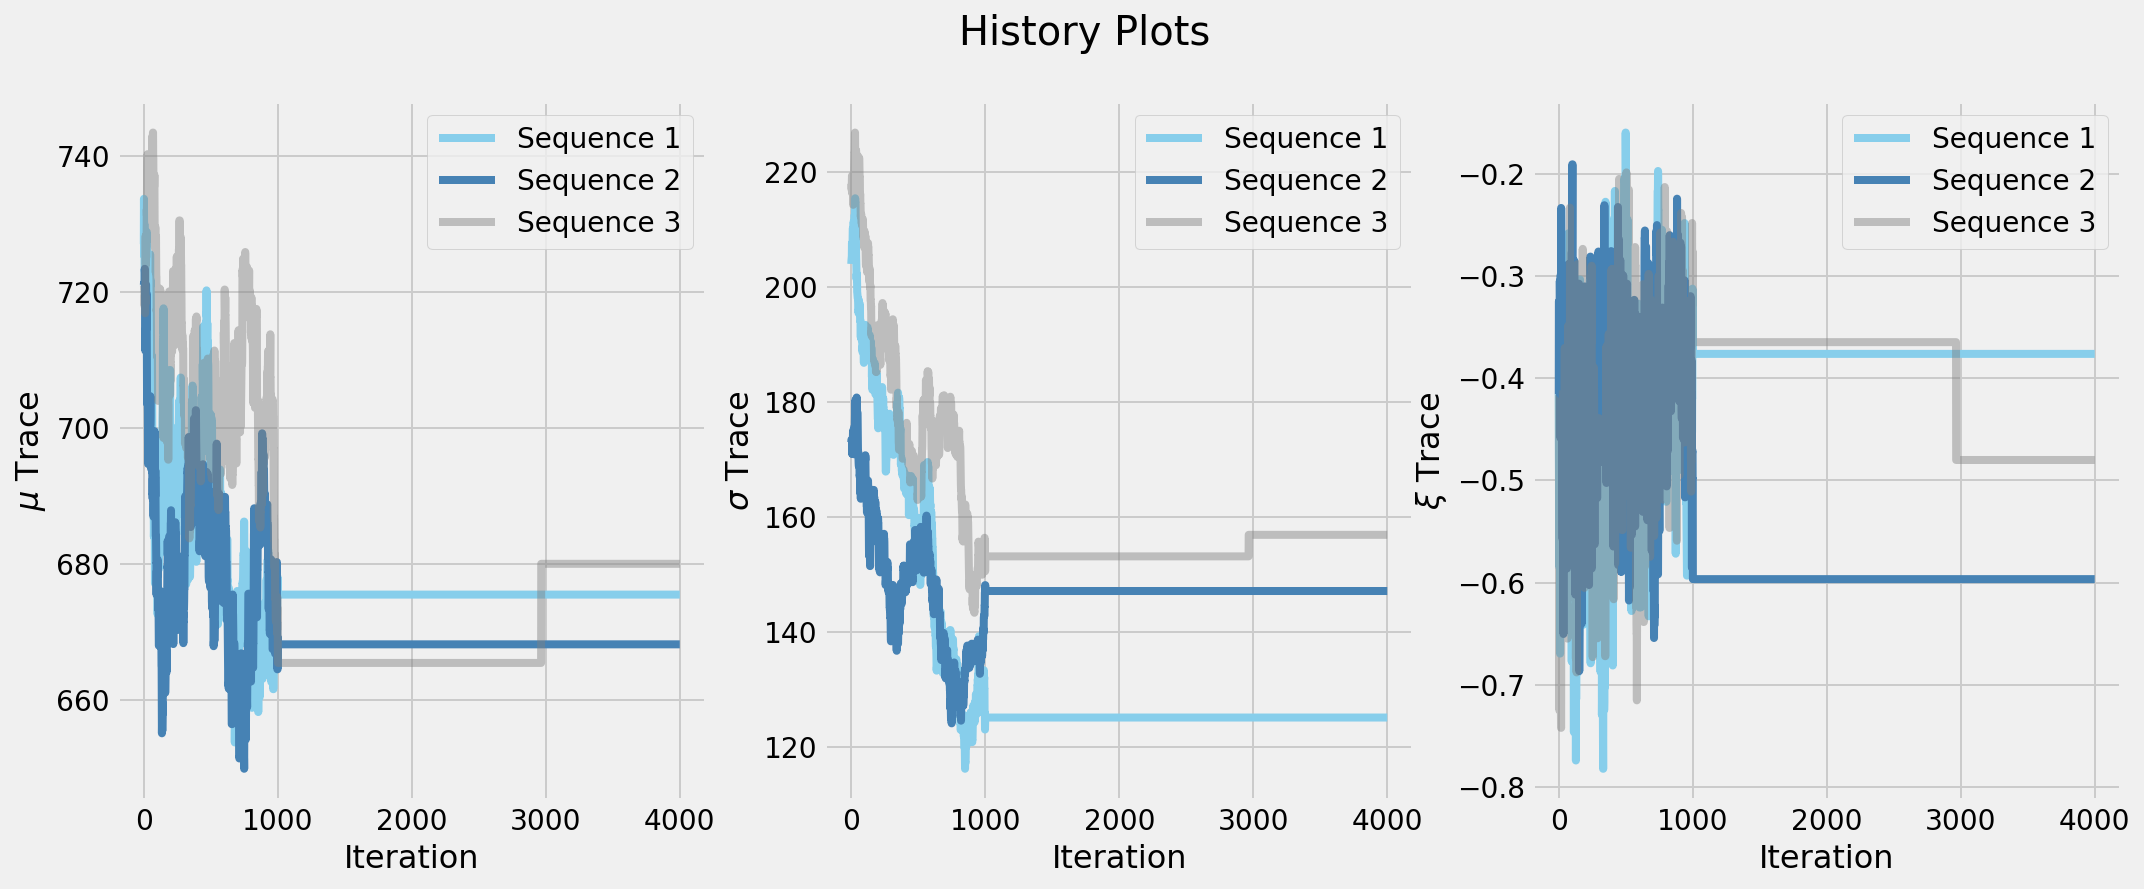

In [79]:
history_plots(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
introductory text/segue...  $$$$
It seems repetitive to revisit why we are doing each of these things, but it is important to have straight in everyone's minds what each section achieves and why we care to do it. And it will help to frame how you present these kinds of materials to (for example) interview committees or when writing a paper.
<span>

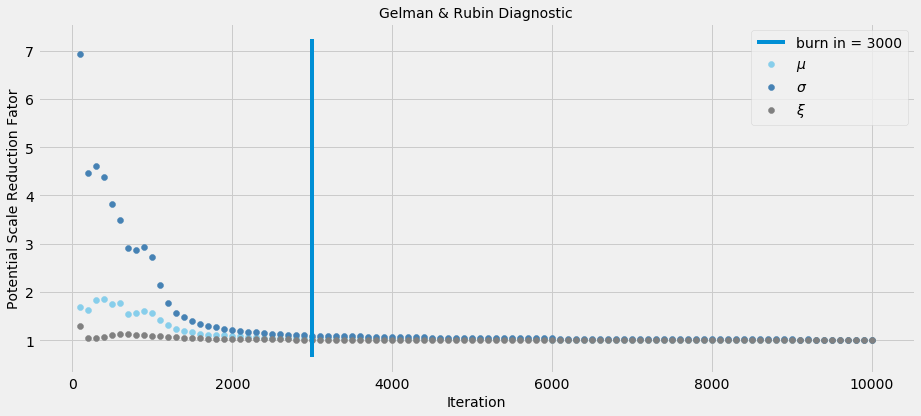

In [19]:
burnin = GR_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], t)

***

<a id='ac-function'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
introductory text/segue...
<span>

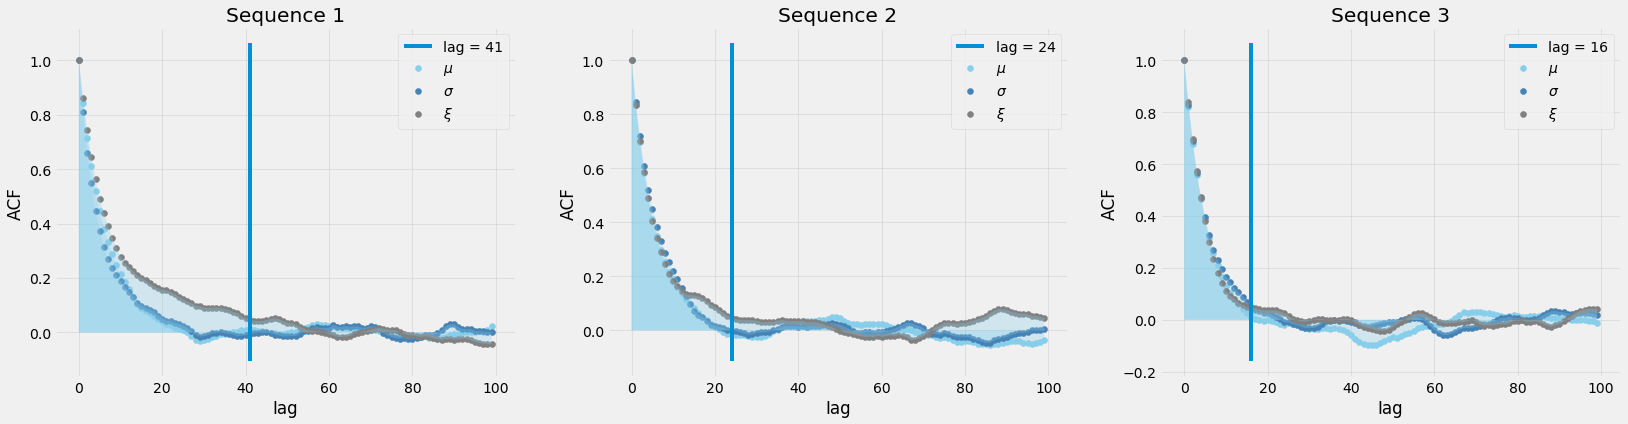

In [20]:
lags = acf_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], burnin)

***

<a id='histograms'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
introductory text/segue...
<span>

In [21]:
def final_params_pool(mcmc_chains, burnin, lags, params, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_pool, params_ana = [], [[] for i in range(d)]
    for i in range(m):
        for j in range(burnin, n, lags[i]):
            params_pool.append([])
            for k in range(d):
                params_ana[k].append(mcmc_chains[i][k][j])
                params_pool[-1].append(mcmc_chains[i][k][j])
            
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=d, figsize=(16,6))
        for i in range(d):
            ax[i].hist(params_ana[i], color="steelblue")
            ax[i].set_xlabel(params[i])
            ax[i].set_ylabel("Frequency")
            ax[i].grid(alpha=0.5)
        plt.show()  
    return params_pool

<span style='color:red'>**TW:**
These can be shorter, and shoudl be density plots, with no y-tick marks labeled. The ACF plots above have a nice aspect ratio. And include edgecolors to distinguish more easily between bins.
<span>

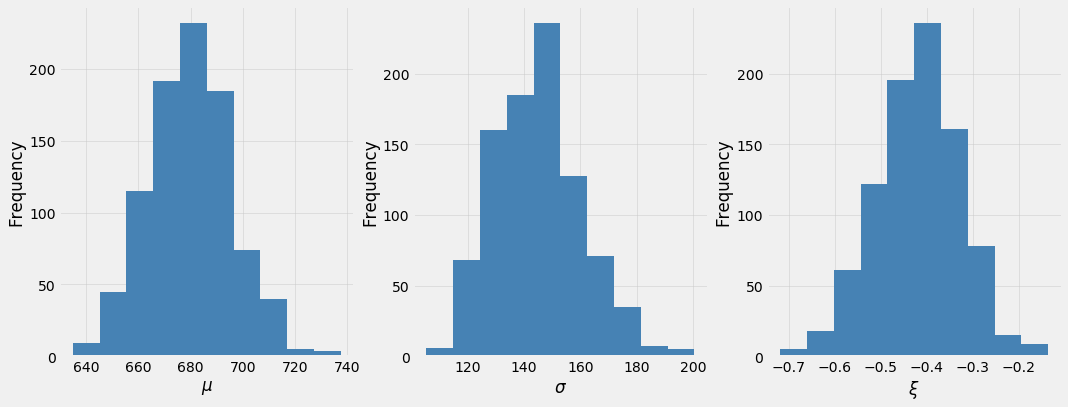

In [22]:
params_analysis = final_params_pool(mcmc_chains, burnin, lags, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='max-ls'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Include units for each parameter (only $\mu$ actually has units), and truncate after a couple decimal places. Also include some introductory text saying that we might be interested in checking out the maximum posterior score parameter set, bla bla bla...
<span>

In [23]:
def max_ls_parameters(ls, mcmc_chains):
    max_indices = []
    maxs = []
    for i in range(len(mcmc_chains)):
        max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
        maxs.append(np.array(ls[i]).max())
    seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
    iterj = max_indices[seqi]
    max_params = []
    d = len(mcmc_chains[0])
    for i in range(d):
        max_params.append(mcmc_chains[seqi][i][iterj])
    print ('The parameters with max log-posterior score are',max_params)
    return max_params

In [24]:
max_params = max_ls_parameters(ls, mcmc_chains)

The parameters with max log-posterior score are [676.50098303172842, 139.10659736148853, -0.42485695932449352]


***

<a id='diag-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Need to describe these plots again, re-introduce them, and segue from the last section.
<span>

In [25]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))
    
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
cdf = [stats.genextreme.cdf(x=np.sort(data_meas)[i], c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
x_range = np.arange(0, max(data_meas)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]

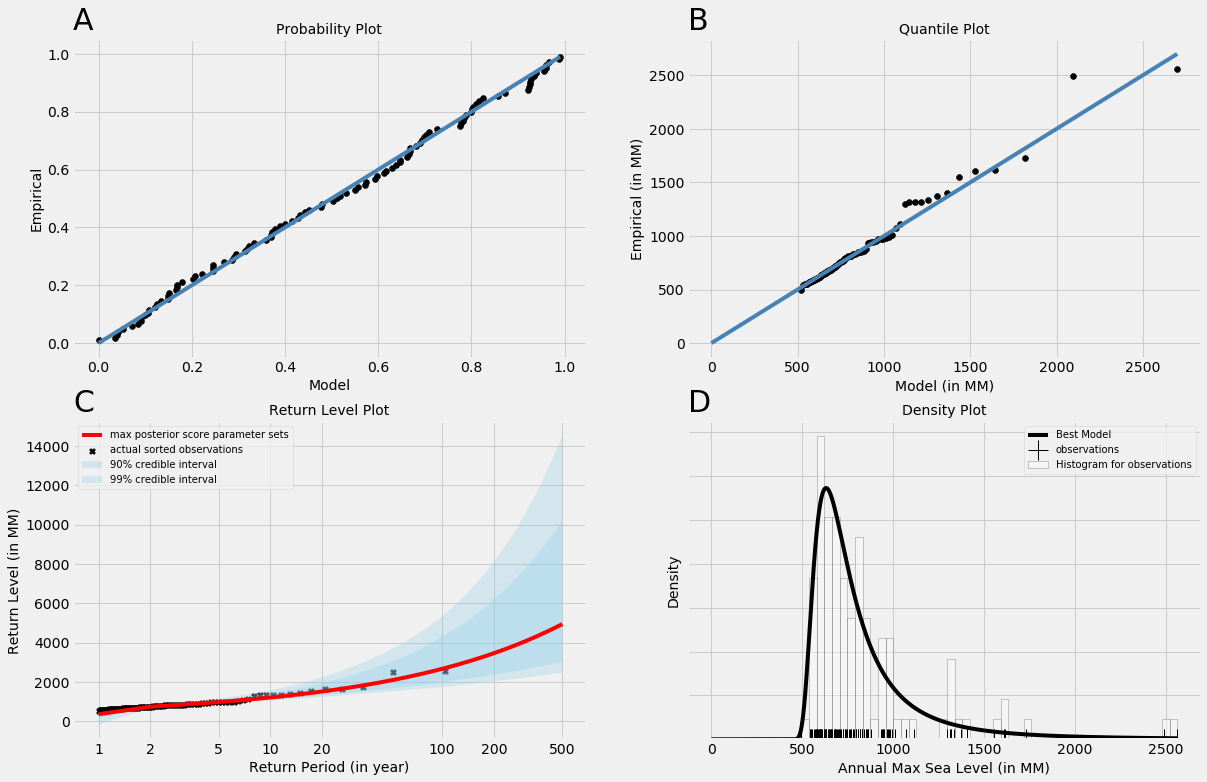

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

ax[0,0].scatter(cdf, [(i+1)/(len(data_meas)+1) for i in range(len(data_meas))], color='black')
ax[0,0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color='steelblue')
ax[0,0].set_title('Probability Plot', fontsize=14)
ax[0,0].set_xlabel('Model', fontsize=14)
ax[0,0].set_ylabel('Empirical', fontsize=14)
ax[0,0].annotate("A", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[0,1].scatter(empirical, np.sort(data_meas), color='black')
ax[0,1].plot(np.arange(0, max(empirical)), np.arange(0, max(empirical)), color='steelblue')
ax[0,1].set_title('Quantile Plot', fontsize=14)
ax[0,1].set_xlabel('Model (in MM)', fontsize=14)
ax[0,1].set_ylabel('Empirical (in MM)', fontsize=14)
ax[0,1].annotate("B", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,0].plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
ax[1,0].scatter(np.log10([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)]), np.sort(data_meas), label='actual sorted observations', color='black', marker='X')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
ax[1,0].legend(loc='upper left', fontsize=10)
ax[1,0].set_xticks(np.log10([1,2,5,10,20,100,200,500]))
ax[1,0].set_xticklabels([1,2,5,10,20,100,200,500])
ax[1,0].set_title('Return Level Plot', fontsize=14)
ax[1,0].set_xlabel('Return Period (in year)', fontsize=14)
ax[1,0].set_ylabel('Return Level (in MM)', fontsize=14)
ax[1,0].annotate("C", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,1].hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
ax[1,1].plot(x_range, y_range, label='Best Model', color='black')
ax[1,1].plot(data_meas, np.zeros_like(data_meas), 'b+', ms=20, color='black', label='observations')
ax[1,1].legend(loc='best', fontsize=10)
ax[1,1].set_yticklabels([])
ax[1,1].set_title('Density Plot', fontsize=14)
ax[1,1].set_xlabel('Annual Max Sea Level (in MM)', fontsize=14)
ax[1,1].set_ylabel('Density', fontsize=14)
ax[1,1].annotate("D", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

plt.show()

<span style='color:red'>**TW:**
Include a section that discusses the implications of these results, and mentions each of the four panels by name. the abbreviation for millimeters ought to be "mm" and you can simply write (e.g.) "Return level (mm)" instead of "in mm". Address in the text things like how well the model fits the data, and how this depends on which quantiles we are trying to examine. Address how wide the uncertainty range is in panel C for example. Also we will want to bring up what are credible intervals! Panel C might not be intuitive to everyone because the distribution of return levels corresponding to a particular return period is coming out of the figure towards the viewer.
$$$$
Include some wrap-up conclusions text.
<span>